In [261]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
from pandas import Series
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dst-scoring/sample_submission.csv
/kaggle/input/dst-scoring/train.csv
/kaggle/input/dst-scoring/test.csv


## Постановка задачи

По данным из датасета, содержащего информацию о банковских клиентах, построить модель, предсказывающую, совершит ли данный заемщик дефолт, для того, чтобы банк мог принимать решение о выдаче кредита данному заемщику. В качестве метрики использовать кривую ROC AUC.

Описание полей

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [262]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [263]:
# import warnings
# warnings.filterwarnings("ignore")

In [264]:
# Импортируем файлы
DATA_DIR = '/kaggle/input/dst-scoring/'
data_train = pd.read_csv(DATA_DIR + 'train.csv')
data_test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + '/sample_submission.csv')

In [265]:
# Проверим размерность тренировочной и тестовой выборок
print('Тренировочный датасет: ', data_train.shape,'\nТестовый датасет: ', data_test.shape)

Тренировочный датасет:  (73799, 19) 
Тестовый датасет:  (36349, 18)


In [266]:
# Объединим тренировочную и тестовую выборку
data_train['sample'] = 1 # помечаем где у нас трейн
data_test['sample'] = 0 # помечаем где у нас тест
data_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

data = data_test.append(data_train, sort=False).reset_index(drop=True) # объединяем

In [267]:
data # набор данных содержит 110148 записей

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,1,0
110144,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,1,0
110145,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,1,0
110146,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1,1


<AxesSubplot:xlabel='default', ylabel='count'>

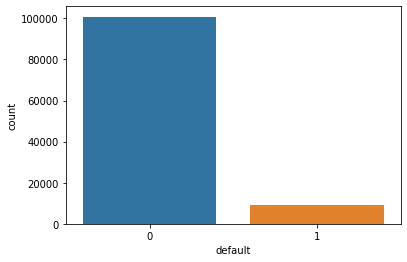

In [268]:
# Построим диаграмму для переменной default. У банка больше клиентов без дефолта
sns.countplot(x = 'default', data = data)

In [269]:
# Посмотрим на тип данных и наличие пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [270]:
# Поиск выбросов
def outliers(col):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    l = perc25 - 1.5*IQR 
    r = perc75 + 1.5*IQR
    print("Для {0} IQR: {1}, ".format(col,IQR),"Границы выбросов: [{0}, {1}].".format(l, r))
    print('Всего {} выбросов'.format(data[data[col] > r][col].count() + data[data[col] < l][col].count()))

In [271]:
# Печать метрик качества
def print_metrics(y_test, y_pred):
    print(
        'Accuracy: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)), 
        'f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)),
        'Recall: {}'.format(np.round(recall_score(y_test, y_pred), 4)),
        'MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)), sep="\n")

In [272]:
# Переформатируем значения для даты
data.app_date = pd.to_datetime(data.app_date)
display(data.app_date.sample(5))

94410   2014-01-14
9730    2014-04-28
80685   2014-02-18
41807   2014-02-01
31056   2014-01-17
Name: app_date, dtype: datetime64[ns]

In [273]:
# Дополнительно убедимся, что год везде один
data.app_date.dt.year.unique()

array([2014])

In [274]:
# Создаем новые признаки
data['app_day'] = data.app_date.dt.day # день месяца
data['app_month'] = data.app_date.dt.month # месяц
data['app_weekday'] = data.app_date.dt.weekday # день недели
data['days'] = (data.app_date - data.app_date.min()).dt.days # количество дней

# Столбец даты больше не нужен в изначальном виде, удалим его
data.drop(['app_date'], axis = 1, inplace = True)

In [275]:
# Проверим номера колонок
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         109670 non-null  object 
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

<AxesSubplot:>

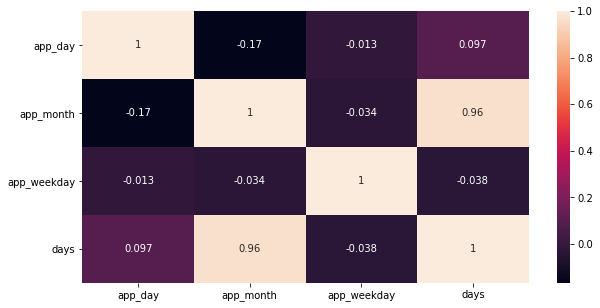

In [276]:
# Оценим новые признаки с помощью матрицы корреляции 
plt.figure(figsize=(10,5))
sns.heatmap(data.iloc[:,19:].corr(), annot=True)

In [277]:
# Увидели, что признаки app_month и days имеют корреляцию, близкую к 1
# Удалим app_month как избыточный
data.drop(['app_month'], axis = 1, inplace = True)

In [278]:
# взглянем на данные об образовании
data.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [279]:
# посмотрим на наличие пропусков
data.education.isna().value_counts()

False    109670
True        478
Name: education, dtype: int64

In [280]:
# заменим пропуски в образовании на наиболее часто встречающееся значение
def fillna(row):
    if pd.isna(row.education) == False:
        return row.education
    else:
        return 'SCH'

In [281]:
data.education = data.apply(lambda row: fillna(row), axis = 1)

In [282]:
# разделим переменные на 3 группы
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = [
    'education', 
    'region_rating', 
    'home_address', 
    'work_address', 
    'sna', 
    'first_time'    
]

# числовые переменные
num_cols = [
    'age', 
    'decline_app_cnt', 
    'income' 
]

<AxesSubplot:>

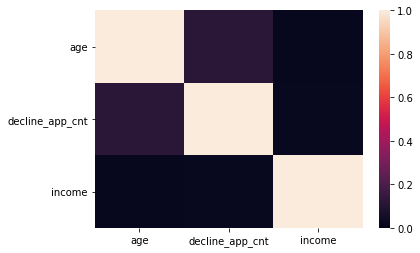

In [283]:
# построим матрицу корреляции для числовых переменных
# видно, что признаки слабо скореллированы друг с другом - можно оставить все
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

In [284]:
# посмотрим на выбросы
outliers('decline_app_cnt')
outliers('income')
outliers('bki_request_cnt')
outliers('score_bki')

Для decline_app_cnt IQR: 0.0,  Границы выбросов: [0.0, 0.0].
Всего 18677 выбросов
Для income IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Всего 7000 выбросов
Для bki_request_cnt IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
Всего 2636 выбросов
Для score_bki IQR: 0.6925455175000004,  Границы выбросов: [-3.299251946250001, -0.5290698762499992].
Всего 518 выбросов


In [285]:
# Посмотрим наиболее частные значения
data.decline_app_cnt.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
15        1
19        1
20        1
21        1
22        1
24        1
30        1
33        1
Name: decline_app_cnt, dtype: int64

In [286]:
# Заменим значения
data.decline_app_cnt = data.decline_app_cnt.apply(lambda x: (x if x < 4 else 4))

# Удалим колонку из списка числовых и добавим в список категориальных
num_cols.remove('decline_app_cnt')
cat_cols.append('decline_app_cnt')

In [287]:
data.bki_request_cnt.value_counts()

0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
24       12
23       12
22        8
25        5
27        5
28        5
26        4
32        4
29        3
40        2
33        2
36        1
34        1
41        1
45        1
46        1
47        1
53        1
Name: bki_request_cnt, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


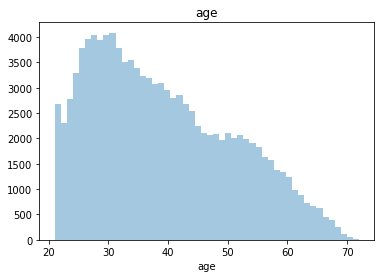

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


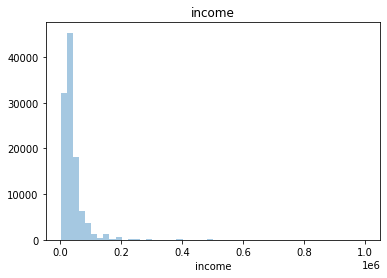

In [288]:
# посмотрим на распределение числовых признаков и затем нормализуем их с помощью логарифмирования
for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [289]:
data.age = np.log10(data["age"] + 1)
data.income = np.log10(data["income"] + 1)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


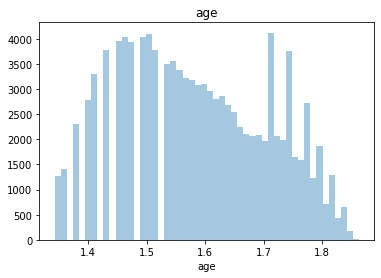

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


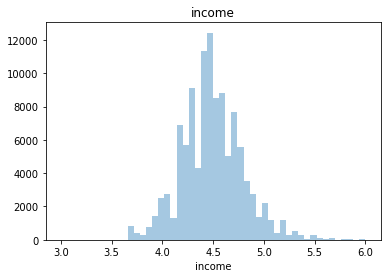

In [290]:
# после логарифмирования распределение приблизилось к нормальному
for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

<AxesSubplot:xlabel='default', ylabel='age'>

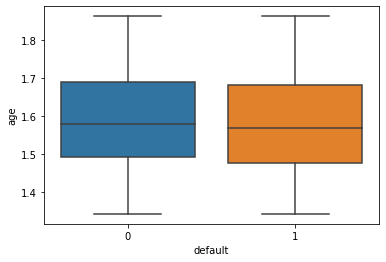

In [291]:
# дефолтные клиенты в среднем младше
sns.boxplot(x = 'default', y = 'age', data = data)

<AxesSubplot:xlabel='default', ylabel='decline_app_cnt'>

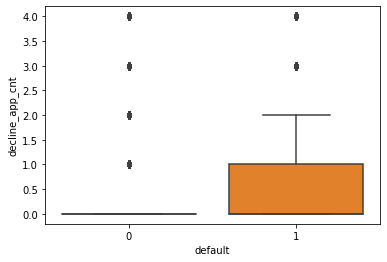

In [292]:
# дефолтные клиенты в среднем имеют большое количество отмененных заявок
sns.boxplot(x = 'default', y = 'decline_app_cnt', data = data)

<AxesSubplot:xlabel='default', ylabel='bki_request_cnt'>

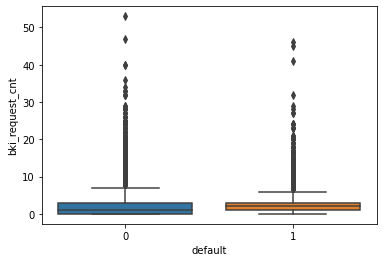

In [293]:
# дефолтные клиенты в среднем имеют больше запросов в БКИ
sns.boxplot(x = 'default', y = 'bki_request_cnt', data = data)

<AxesSubplot:xlabel='default', ylabel='income'>

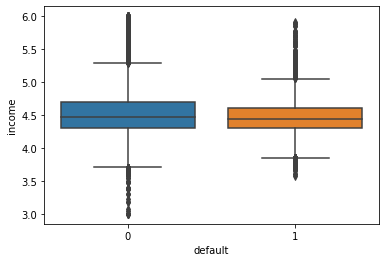

In [294]:
# дефолтные клиенты в среднем имеют более низкий доход
sns.boxplot(x = 'default', y = 'income', data = data)

<AxesSubplot:>

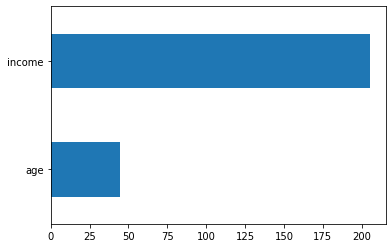

In [295]:
# признак income более значим, чем признак age
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [296]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,sample,default,app_day,app_weekday,days
0,74835,GRD,1,1.477121,1,1,0,0,-2.271884,3,...,2,4.698979,1,4,0,0,0,22,5,80
1,17527,SCH,0,1.602060,0,0,4,0,-1.504999,2,...,2,3.699057,4,3,0,0,0,24,4,23
2,75683,UGR,1,1.707570,1,1,0,0,-1.691339,1,...,2,4.477136,1,3,1,0,0,23,6,81
3,26883,SCH,1,1.755875,0,0,0,0,-2.374182,1,...,2,4.230474,1,3,0,0,0,3,0,33
4,28862,GRD,0,1.591065,0,0,0,0,-2.487502,0,...,3,5.079185,1,3,0,0,0,4,1,34


In [297]:
# Для категориальных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in cat_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,sample,default,app_day,app_weekday,days
0,74835,1,1,1.477121,1,1,0,0,-2.271884,3,...,1,4.698979,0,3,0,0,0,22,5,80
1,17527,3,0,1.602060,0,0,4,0,-1.504999,2,...,1,3.699057,3,2,0,0,0,24,4,23
2,75683,4,1,1.707570,1,1,0,0,-1.691339,1,...,1,4.477136,0,2,1,0,0,23,6,81
3,26883,3,1,1.755875,0,0,0,0,-2.374182,1,...,1,4.230474,0,2,0,0,0,3,0,33
4,28862,1,0,1.591065,0,0,0,0,-2.487502,0,...,2,5.079185,0,2,0,0,0,4,1,34


<AxesSubplot:>

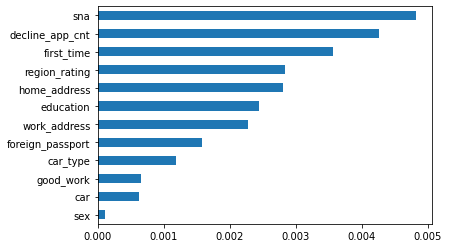

In [298]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [299]:
from sklearn.preprocessing import PolynomialFeatures
# добавим новые полиномиальные признаки
pf = PolynomialFeatures(2, include_bias = False)
poly_data = pf.fit_transform(data[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
data = data.join(poly_df,  how='left')

In [300]:
data

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,first_time,foreign_passport,sample,default,app_day,app_weekday,days,x0^2,x0 x1,x1^2
0,74835,1,1,1.477121,1,1,0,0,-2.271884,3,...,3,0,0,0,22,5,80,2.181887,6.940961,22.080401
1,17527,3,0,1.602060,0,0,4,0,-1.504999,2,...,2,0,0,0,24,4,23,2.566596,5.926111,13.683022
2,75683,4,1,1.707570,1,1,0,0,-1.691339,1,...,2,1,0,0,23,6,81,2.915796,7.645023,20.044744
3,26883,3,1,1.755875,0,0,0,0,-2.374182,1,...,2,0,0,0,3,0,33,3.083097,7.428184,17.896914
4,28862,1,0,1.591065,0,0,0,0,-2.487502,0,...,2,0,0,0,4,1,34,2.531487,8.081311,25.798119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,1,0,1.662758,0,0,0,0,-1.792064,3,...,3,0,1,0,4,1,62,2.764764,7.034255,17.896914
110144,76821,3,1,1.623249,1,1,0,0,-2.058029,1,...,3,0,1,0,24,0,82,2.634938,7.864812,23.475035
110145,103695,3,1,1.505150,0,0,0,0,-1.512635,4,...,1,0,1,0,22,1,111,2.265476,7.003797,21.652477
110146,861,3,0,1.477121,0,0,0,1,-1.479334,3,...,2,0,1,1,4,5,3,2.181887,6.076843,16.924805


In [301]:
# обозначим X и Y
X = data.drop(['default'], axis = 1)
Y = data['default']

In [302]:
# проверка на наличие пропусков
X.isna().value_counts()

client_id  education  sex    age    car    car_type  decline_app_cnt  good_work  score_bki  bki_request_cnt  region_rating  home_address  work_address  income  sna    first_time  foreign_passport  sample  app_day  app_weekday  days   x0^2   x0 x1  x1^2 
False      False      False  False  False  False     False            False      False      False            False          False         False         False   False  False       False             False   False    False        False  False  False  False    110148
dtype: int64

In [303]:
# разделяем выборку на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, shuffle=True)

In [304]:
# обучаем 1 модель
lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train,y_train)
y_pred = lr.predict_proba(X_test)
y_pred = y_pred[:,1]

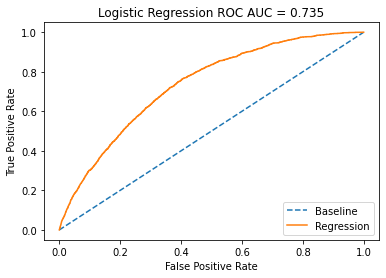

In [305]:
# визуализация ROC-анализа
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()


In [306]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
clf = DecisionTreeClassifier(random_state=23)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
f1_train = f1_score(y_train, y_pred)
y_pred = clf.predict(X_test)
f1_test = f1_score(y_test, y_pred)
print(f1_train)
print(round(f1_test),2)

1.0
0 2


In [307]:
# построение confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[18427,  1761],
       [ 1418,   424]])

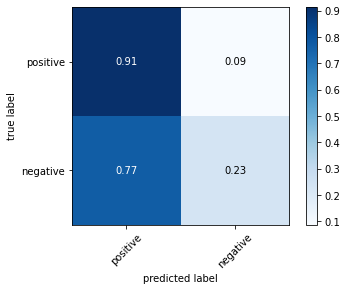

In [308]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
classes = ['positive', 'negative']

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

In [309]:
# подбираем лучшие параметры
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('classifier' , LogisticRegression())])




param_grid = [
    {'classifier' : [LogisticRegression()],
'classifier__penalty' : ['l1', 'l2','elasticnet', 'none'],
'classifier__C' : np.logspace(0, 4, 10),
'classifier__solver' : ['liblinear', 'newton', 'lbfgs', 'sag', 'saga'],
'classifier__multi_class': ['auto', 'ovr', 'multinomial']
}]



clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)



best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1517 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 2180 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 23.8min finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [310]:
best_clf.best_params_

{'classifier': LogisticRegression(penalty='l1', solver='saga'),
 'classifier__C': 1.0,
 'classifier__multi_class': 'auto',
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [311]:
# применение логистической регрессии (solver = 'liblinear' больше подходит)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear', class_weight = 'balanced')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [312]:
probs = lr.predict_proba(X_test)
probs = probs[:,1]

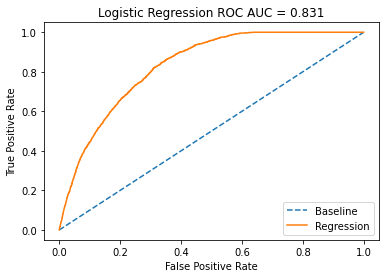

In [313]:
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [314]:
# Делим датасет на тренировочный и тестовый
data_train = data.query('sample == 1').drop(['sample'], axis = 1)
data_test = data.query('sample == 0').drop(['sample'], axis = 1)

In [315]:
# Стандартизация числовых переменных
num_cols_std = StandardScaler().fit_transform(data_train[num_cols].values)

In [316]:
# Выделим целевую переменную
X = np.hstack([data_train.drop(num_cols + ['default'], axis=1), num_cols_std])
Y = data_train['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

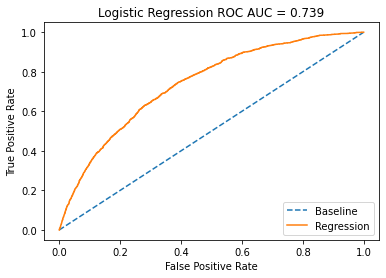

In [317]:
lr = LogisticRegression(penalty = 'l1', class_weight = 'balanced', max_iter = 1000, solver = 'liblinear', C = 1)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
probs = lr.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [318]:
# Стандартизируем тестовые данные
num_cols_test_std = StandardScaler().fit_transform(data_test[num_cols].values)
X_test = np.hstack([data_test.drop(num_cols + ['default'], axis=1), num_cols_test_std])
y_probs = lr.predict_proba(X_test)[:,1]

In [319]:
submission = pd.DataFrame(data_test.client_id)
submission['default'] = y_probs
submission.to_csv('submission.csv', index = False)
submission.sample(10)

,client_id,default
22139,77293,0.541858
10395,72559,0.516893
14696,62269,0.397654
1252,16801,0.266243
14365,49984,0.365937
22546,10399,0.671291
21891,81343,0.309840
15620,62163,0.200264
32206,67638,0.120882
9210,19909,0.495331
